# The lumped kinetic model (LKM)

Marek Szymanski

In [1]:
import scipy.integrate

In [2]:
from sparsegrad.base import *
from sparsegrad.forward import nvalue

N=1000

def f_langmur(c, params):
    return params.a*c/(1.+params.b*c)

def internal_ode(c, q, c_dz, c_ddz, params, f):
    qstar = f(c, params)
    d=qstar-q
    c_dt = -params.u*c_dz + params.D * c_ddz - params.k/params.epsilon*d
    q_dt = params.k/(1-params.epsilon) * d
    return c_dt, q_dt

def cinj_prescribed(t, params):
    return where(t<=params.tinj, params.cinj, 0)

In [3]:
def ode(t, x, params, f):
    L=params.L
    h=L/(N-1)
    c_int = x[0:N-2]
    q_int = x[N-2:2*N-4]
    # BC0: Solve -params.D/params.u * c_dz[0] + c[0] - cinj_prescribed(t, params) for c[0]
    v = -params.D/params.u
    bc0 = (cinj_prescribed(t, params) - v*c_int[0]/h)/(1-v/h)
    # BC1: 
    bc1 = c_int[-1]
    c = stack(bc0, c_int, bc1)
    h = L/(N-1)
    c_dz = (c[1:]-c[:-1]) / h
    c_dz_sym = 0.5*(c_dz[:-1]+c_dz[1:])
    c_ddz = (c_dz[1:]-c_dz[:-1]) / h
    assert np.allclose(nvalue(-params.D/params.u * c_dz[0] + c[0]), cinj_prescribed(t, params))
    assert np.allclose(nvalue(c_dz[-1]), 0)
    return stack(*internal_ode(c_int, q_int, c_dz_sym, c_ddz, params, f))

In [4]:
from collections import namedtuple
params_type = namedtuple('params', ['L','D', 'u', 'a', 'b', 'epsilon', 'cinj', 'tinj','k'])    

In [5]:
params_table = params_type(L=1e-2, 
                           epsilon=0.4, 
                           u=1e-2/60, 
                           D=2e-8/60,
                           cinj=1e-3/1e-3, 
                           a=1, 
                           #b=0.1e-3/1e-3,
                           b=0,
                           tinj=3*60, 
                           k=100/60)

In [6]:
import numpy as np

In [7]:
from sparsegrad.forward import seed

In [8]:
cinit = 0 
qinit = 0
x0 = np.zeros(2*N-4)
x0[:N-2] = cinit
x0[N-2:2*N-4] = qinit

In [9]:
%matplotlib inline
import matplotlib.pylab as plt

In [10]:
x = x0
def jac(t, x):
    return ode(t, seed(x), params_table, f_langmur).dvalue.tocsr()
def func(t, x):
    return ode(t,x,params_table,f_langmur)
result = scipy.integrate.solve_ivp(func, [0, 8*60], x0, method='Radau', jac=jac, rtol=1e-6, atol=1e-8)

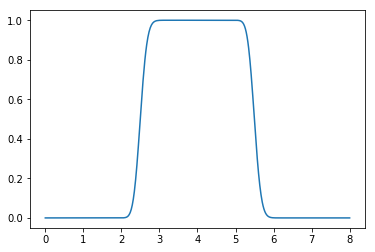

In [11]:
plt.plot(result.t/60, result.y[N-3,:])

In [12]:
import ipywidgets

def plot(i=ipywidgets.IntSlider(min=0,max=len(result.t)-1)):
    print('time = ', result.t[i])
    plt.plot(result.y[:N-2,i])
    plt.show()

ipywidgets.interact(plot)

interactive(children=(IntSlider(value=0, description='i', max=917), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(i=IntSlider(value=0, description='i', max=917))>